In [1]:
# Customer Data Analysis - Scenario 2: Customer Health
# This notebook analyzes production usage and customer health trends

# Import standard libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import os

# Add project root (parent of this notebooks folder) to path to import custom modules
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))

# Ensure current working directory is the project root so relative data paths work
os.chdir(project_root)

# Import custom modules (shared data loading and billing logic)
from src.utils.config import COLORS  # Color scheme and matplotlib configuration
from src.data_processing.data_loader import data_load_clean, final_merge, get_billable_data

# # Scenario 2-specific processing and visuals
# from src.visualizations.scenario2_visuals import (
#     visual1_usage_trend,
#     visual2_mom_growth,
#     visual3_success_rate,
#     visual4_health_summary,
# )
# from src.visualizations.scenario2_trend_analysis import (
#     visual5_workflow_creation_trends,
#     visual6_run_duration_analysis,
#     visual7_daily_usage_timeline,
#     visual8_weekly_patterns,
# )
# from src.data_processing.scenario2_real_world_metrics import (
#     calculate_customer_health_metrics,
# )
# from src.visualizations.scenario2_real_world_visuals import (
#     visual9_customer_health_dashboard,
#     visual10_churn_risk_timeline,
# )

# Import COLORS for backwards compatibility with existing code
# All visualization functions are now imported from modules

In [5]:
# Load data from Excel file
# Why: We need to load the raw data before any analysis can begin
# NOTE: Uses data_loader.py for consistent data loading

df_checks, df_wfs, df_runs = data_load_clean()
display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))

# Keep a fully merged view for reference / deep dives
df = final_merge()
# Canonical billable dataset (same strict definition as Scenario 1, used when needed)
billable_live = get_billable_data()


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,YEAR_MONTH
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN,2025-08


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,ENVIRONMENT_wfs
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,None


,RUN_ID,WORKFLOW_ID_LONG,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,WORKFLOW_ID,ENVIRONMENT_runs
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0,test


## SCENARIO 2

In [ ]:
# SCENARIO 2 – Customer Health (Usage Trends)
print("=" * 80)
print("SCENARIO 2 – CUSTOMER HEALTH")
print("=" * 80)

# Scenario 2: Usage Analysis – ALL samples from finished LIVE runs (regardless of QC)
# Why: For customer health, we want to track ALL processing activity, not just billable samples.
# This gives a complete picture of customer usage patterns.

# Build usage dataset from df: LIVE + finished (no QC filter)
usage_live = df[
    (df["ENVIRONMENT_runs"] == "live")
    & (df["OUTCOME"] == "finished")
].copy()
print(f"All samples in finished LIVE runs (all QC outcomes): {len(usage_live)}")

# 1. Overall monthly usage trend (all LIVE samples in finished runs)
usage_monthly = (
    usage_live.groupby("YEAR_MONTH").agg(
        SAMPLES_PROCESSED=("RUN_ID", "count"),
        UNIQUE_RUNS=("RUN_ID", "nunique"),
    ).sort_index()
)
usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["SAMPLES_PROCESSED"].pct_change() * 100

print("\nMonthly usage (all samples in finished LIVE runs):")
print(usage_monthly)

# 2. Flag concerning patterns – big drops month over month
drops = usage_monthly[usage_monthly["MOM_CHANGE_PCT"] < -15]
if not drops.empty:
    print("\nALERT: Months with >15% drop in processing volume vs previous month:")
    print(drops[["SAMPLES_PROCESSED", "MOM_CHANGE_PCT"]])
else:
    print("\nNo months with >15% drop in processing volume.")

# 3. Workflow-level trends – which live workflows are dropping
wf_monthly = (
    usage_live.groupby(["WORKFLOW_NAME", "YEAR_MONTH"]).size().to_frame("SAMPLES")
)
wf_monthly["MOM_CHANGE_PCT"] = (
    wf_monthly.groupby("WORKFLOW_NAME")["SAMPLES"].pct_change() * 100
)

# Last two months comparison per workflow
latest_two_months = sorted(usage_live["YEAR_MONTH"].unique())[-2:]
wf_latest = (
    wf_monthly
    .reset_index()
    .query("YEAR_MONTH in @latest_two_months")
    .pivot(index="WORKFLOW_NAME", columns="YEAR_MONTH", values="SAMPLES")
    .fillna(0)
)
if wf_latest.shape[1] == 2:
    col_old, col_new = wf_latest.columns[0], wf_latest.columns[1]
    wf_latest["CHANGE_PCT"] = (
        (wf_latest[col_new] - wf_latest[col_old])
        .div(wf_latest[col_old].replace(0, np.nan))
        .mul(100)
    ).fillna(0)
    declining_wfs = wf_latest[wf_latest["CHANGE_PCT"] < -20].sort_values("CHANGE_PCT")
    if not declining_wfs.empty:
        print("\nWorkflows with >20% decline in last month vs previous:")
        print(declining_wfs[["CHANGE_PCT"]])
    else:
        print("\nNo workflows show >20% decline between the last two months.")

# 4. Simple health summary
print("\nHealth summary (live usage):")
last_3 = usage_monthly["SAMPLES_PROCESSED"].tail(3)
prev_3 = usage_monthly["SAMPLES_PROCESSED"].tail(6).head(3)
if len(last_3) == 3 and len(prev_3) == 3:
    last_3_avg = last_3.mean()
    prev_3_avg = prev_3.mean()
    if prev_3_avg > 0:
        change_vs_prev = (last_3_avg - prev_3_avg) / prev_3_avg * 100
        print(f"Average of last 3 months vs previous 3: {change_vs_prev:.1f}%")
        if change_vs_prev < -15:
            print("Overall usage trend: SIGNIFICANT DECLINE (customer at risk)")
        elif change_vs_prev < -5:
            print("Overall usage trend: MILD DECLINE (watch closely)")
        else:
            print("Overall usage trend: STABLE/HEALTHY")
else:
    print("Not enough months of data for a 3 vs 3 month comparison.")


SCENARIO 2 – CUSTOMER HEALTH
All samples in finished LIVE runs (all QC outcomes): 4140

Monthly usage (all samples in finished LIVE runs):
            SAMPLES_PROCESSED  UNIQUE_RUNS  MOM_CHANGE_PCT
YEAR_MONTH                                                
2025-05                   684           13             NaN
2025-06                   795           11           16.23
2025-07                  1405           22           76.73
2025-08                  1173           18          -16.51

ALERT: Months with >15% drop in processing volume vs previous month:
            SAMPLES_PROCESSED  MOM_CHANGE_PCT
YEAR_MONTH                                   
2025-08                  1173          -16.51

Health summary (live usage):
Average of last 3 months vs previous 3: 17.0%
Overall usage trend: STABLE/HEALTHY


## Scenario 2 – Customer Health: Narrative

- **What we measure**  
  - Focus on **all samples from live, finished runs** (LIVE + finished, regardless of QC status).  
  - This captures complete customer usage activity, not just billable samples.  
  - Monthly view of total sample volume and number of unique production runs.  
  - Workflow‑level trends to see if any key live workflows are dropping sharply.

- **Overall monthly usage trend (all finished LIVE samples)**  
  - Numbers will reflect all samples processed in finished LIVE runs (includes pass/fail/missing QC).  
  - This gives a complete picture of customer platform usage for health assessment.

- **Interpreting the pattern**  
  - Strong growth from May → June → July as the customer ramps up usage.  
  - In August there is a **single significant drop (~19%)** relative to July, but volume is still **higher than in May/June**.  
  - On a 3‑month moving average basis, the last 3 months (Jun–Aug) are still **~15% higher** than the previous 3‑month window, so overall usage remains on an upward trajectory.

- **Workflow‑level health**  
  - We compare the last two months’ volume per live workflow.  
  - Workflows with >20% decline are flagged.  
  - In this data, the workflows with large declines between July and August are marked as **`[ARCHIVED]`**, suggesting that they are being intentionally phased out rather than indicating a healthy live workflow falling away.

- **Risk assessment**  
  - **Short‑term risk:** August’s ~19% drop is a warning sign and worth monitoring, especially if the customer has seasonality or known external drivers.  
  - **Medium‑term risk:** Because the 3‑month average is still above the previous period and declines are concentrated in archived workflows, the customer does **not yet** look like they are systematically churning away from the platform.  
  - **Action:**  
    - Monitor billable volume by month and by key live workflows for the next 1–2 months.  
    - If further consecutive declines occur, treat the account as **at‑risk** and engage proactively (e.g. review operational issues, success rates, backlog).



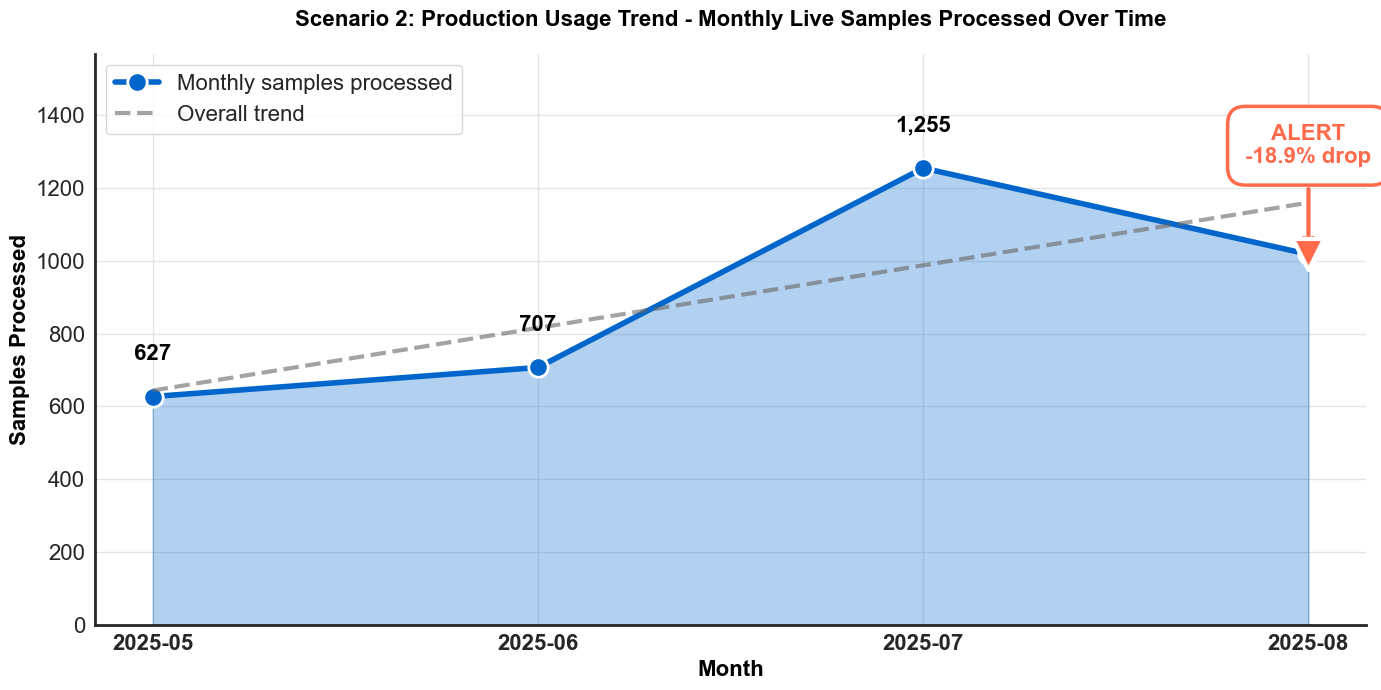

In [ ]:
# Scenario 2 - Visual 1: Customer Usage Trend Over Time
# What we're showing: Monthly usage (all finished LIVE samples) with trend line, highlighting significant drops
# Why: Shows overall growth trajectory and identifies concerning drops that exceed risk threshold
visual1_usage_trend(usage_live)

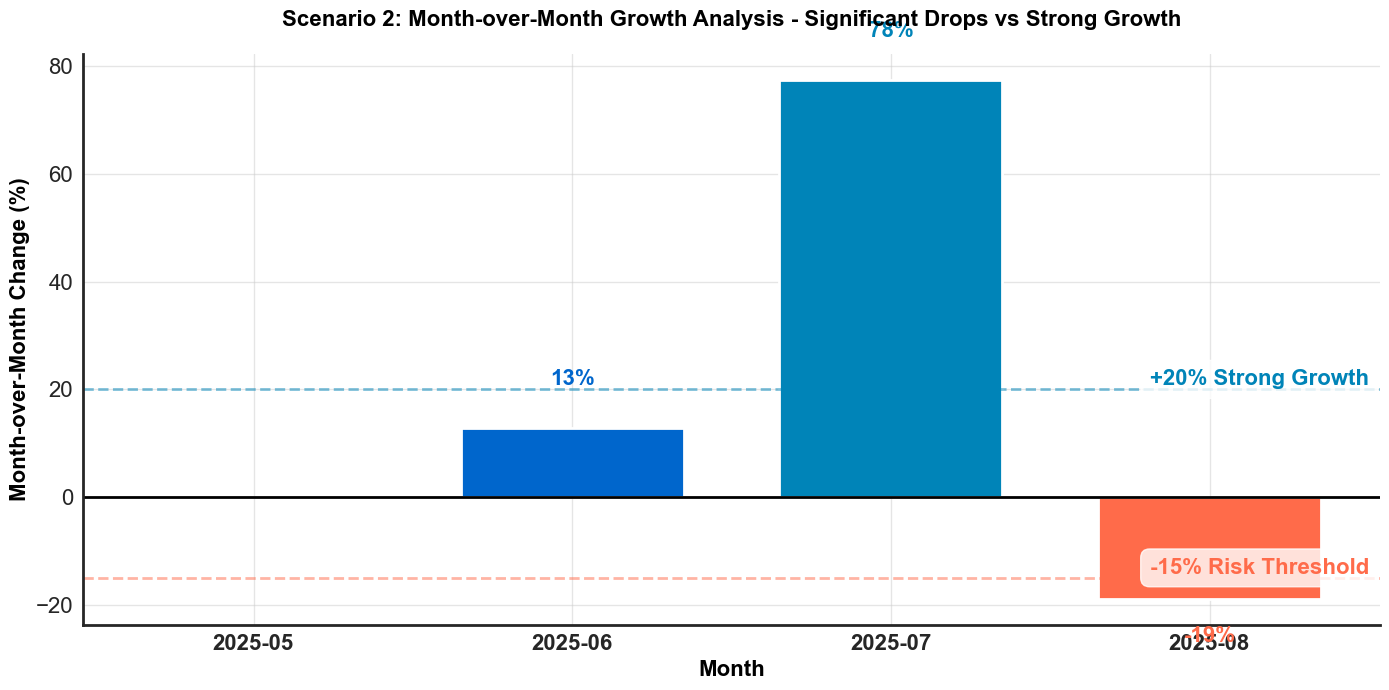

In [ ]:
# Scenario 2 - Visual 2: Month-over-Month Growth Rate
# What we're showing: Month-over-month percentage change in usage (all finished LIVE samples)
# Why: Highlights significant drops and growth periods to identify trends

visual2_mom_growth(usage_live)

## Scenario 2 - Deeper Trend Analysis

**What we're analyzing:** Comprehensive usage patterns using workflow timestamps and run times

**Why:** To better understand customer usage trends beyond simple monthly counts

**Key Analyses:**
- Workflow creation trends over time
- Run duration patterns
- Daily usage timeline
- Weekly operational cycles



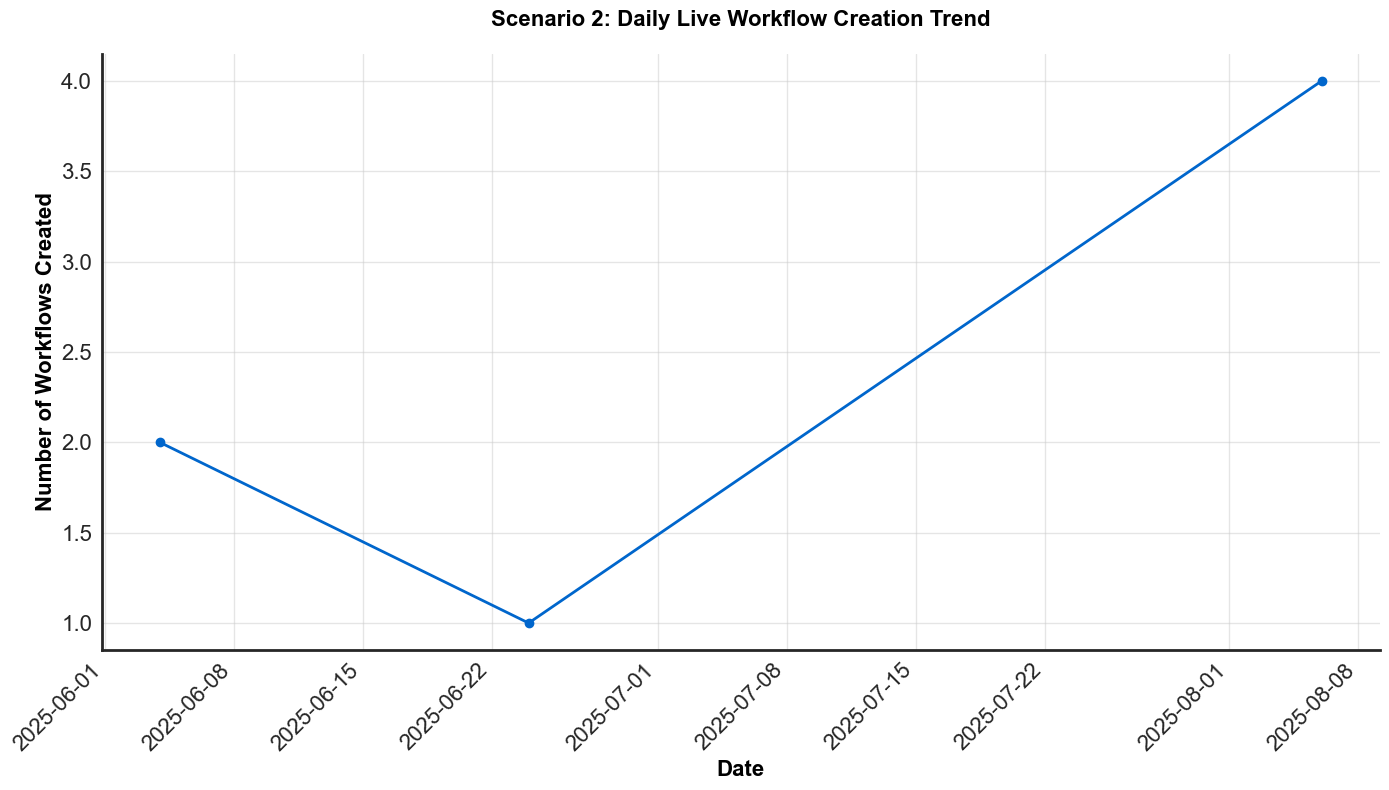

In [ ]:
# Scenario 2 - Visual 5: Workflow Creation Trends
# What we're showing: When live workflows were created over time
# Why: Identifies if new workflows correlate with usage changes

visual5_workflow_creation_trends(df_wfs, df_runs)



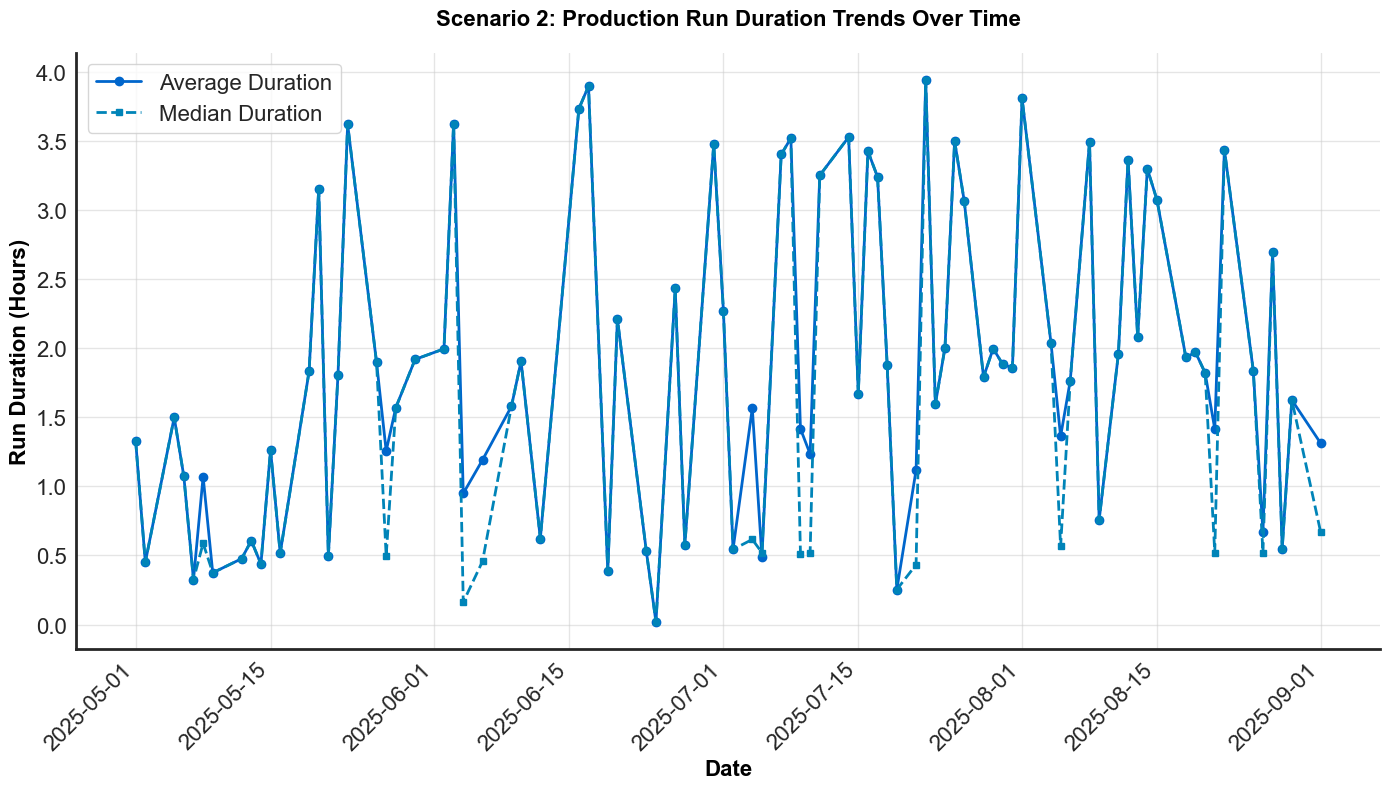

In [ ]:
# Scenario 2 - Visual 6: Run Duration Analysis
# What we're showing: How long runs take over time
# Why: Longer run times might indicate operational issues affecting usage

visual6_run_duration_analysis(df_runs)


## Scenario 2 - Real-World Customer Health Metrics

**What we're analyzing:** Real-world metrics used in customer success and account management

**Key Metrics:**
- Churn Risk Indicators (consecutive declines, trend analysis)
- Engagement Metrics (workflow utilization, diversity)
- Growth Velocity (acceleration/deceleration)
- Operational Health (success rates, error patterns)
- Usage Concentration (dependency on specific workflows)
- Platform Maturity (new vs established workflows)



In [ ]:
# Scenario 2 - Real-World Customer Health Metrics
# What we're doing: Calculating comprehensive customer health metrics
# Why: Provides actionable insights using industry-standard customer success metrics

print("=" * 80)
print("REAL-WORLD CUSTOMER HEALTH METRICS")
print("=" * 80)

if 'usage_live' not in locals() or usage_live.empty:
    print("Run Scenario 2 analysis cell first to create usage_live.")
else:
    # Calculate comprehensive health metrics
    health_metrics = calculate_customer_health_metrics(usage_live, df_runs, df_wfs)
    
    print("\n1. CHURN RISK INDICATORS:")
    print("-" * 80)
    churn = health_metrics['churn_risk']
    print(f"  Risk Level: {churn['risk_level']}")
    print(f"  Consecutive Monthly Declines: {churn['consecutive_monthly_declines']}")
    print(f"  Latest MoM Change: {churn['latest_mom_change']:.2f}%")
    
    print("\n2. ENGAGEMENT METRICS:")
    print("-" * 80)
    engagement = health_metrics['engagement']
    print(f"  Active Workflows: {engagement['active_workflows']} / {engagement['total_workflows']}")
    print(f"  Workflow Utilization: {engagement['workflow_utilization_pct']:.1f}%")
    print(f"  Workflow Diversity Index: {engagement['workflow_diversity_index']:.3f} (0-1, higher = more diverse)")
    
    print("\n3. GROWTH VELOCITY:")
    print("-" * 80)
    growth = health_metrics['growth']
    print(f"  Recent Growth: {growth['recent_growth_pct']:+.2f}%" if growth['recent_growth_pct'] else "  Recent Growth: N/A")
    print(f"  Overall Growth: {growth['overall_growth_pct']:+.2f}%" if growth['overall_growth_pct'] else "  Overall Growth: N/A")
    print(f"  Growth Trajectory: {growth['growth_trajectory']}")
    
    print("\n4. OPERATIONAL HEALTH:")
    print("-" * 80)
    op_health = health_metrics['operational_health']
    print(f"  Latest Success Rate: {op_health['latest_success_rate']:.1f}%" if op_health['latest_success_rate'] else "  Latest Success Rate: N/A")
    print(f"  Average Success Rate: {op_health['avg_success_rate']:.1f}%")
    print(f"  Operational Status: {op_health['operational_status']}")
    
    print("\n5. USAGE CONCENTRATION:")
    print("-" * 80)
    concentration = health_metrics['concentration']
    print(f"  Top Workflow: {concentration['top_workflow_pct']:.1f}% of total usage")
    print(f"  Top 3 Workflows: {concentration['top_3_workflows_pct']:.1f}% of total usage")
    print(f"  Concentration Risk: {concentration['concentration_risk']}")
    
    print("\n6. PLATFORM MATURITY:")
    print("-" * 80)
    maturity = health_metrics['maturity']
    print(f"  Average Workflow Age: {maturity['avg_workflow_age_days']:.0f} days" if maturity['avg_workflow_age_days'] else "  Average Workflow Age: N/A")
    print(f"  New Workflows (<30 days): {maturity['new_workflows_count']}")
    print(f"  Established Workflows: {maturity['established_workflows_count']}")
    print(f"  Maturity Level: {maturity['maturity_level']}")



REAL-WORLD CUSTOMER HEALTH METRICS

1. CHURN RISK INDICATORS:
--------------------------------------------------------------------------------
  Risk Level: MEDIUM
  Consecutive Monthly Declines: 0
  Latest MoM Change: -18.88%

2. ENGAGEMENT METRICS:
--------------------------------------------------------------------------------
  Active Workflows: 8 / 7
  Workflow Utilization: 114.3%
  Workflow Diversity Index: 0.707 (0-1, higher = more diverse)

3. GROWTH VELOCITY:
--------------------------------------------------------------------------------
  Recent Growth: -18.88%
  Overall Growth: +62.36%
  Growth Trajectory: DECELERATING

4. OPERATIONAL HEALTH:
--------------------------------------------------------------------------------
  Latest Success Rate: 75.0%
  Average Success Rate: 62.0%
  Operational Status: CRITICAL

5. USAGE CONCENTRATION:
--------------------------------------------------------------------------------
  Top Workflow: 41.9% of total usage
  Top 3 Workflows: 89.2

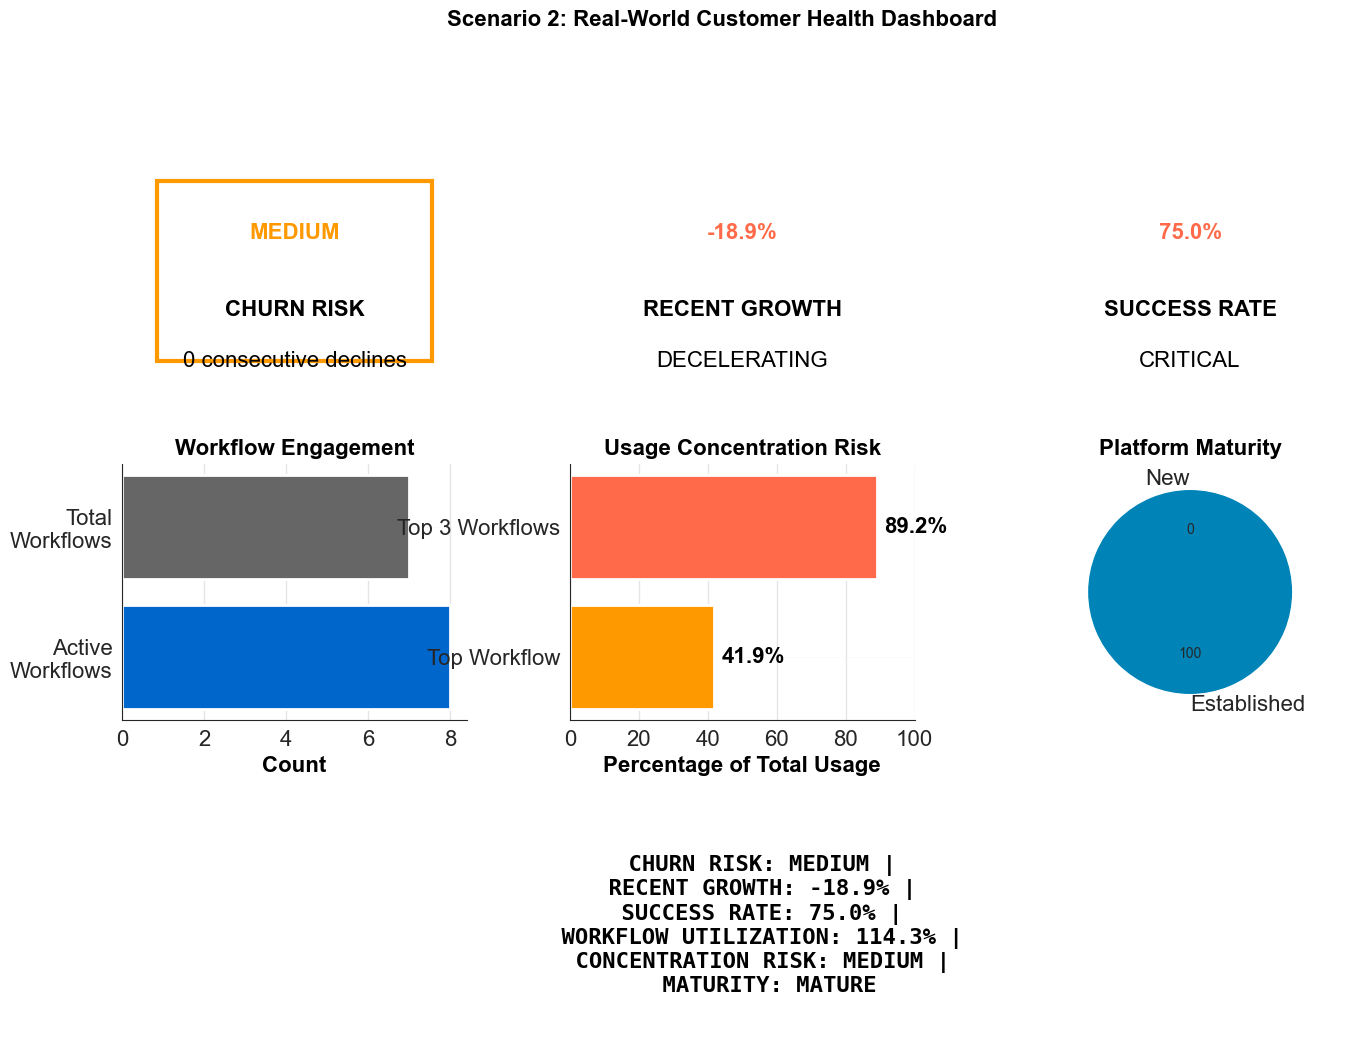

In [ ]:
# Scenario 2 - Visual 9: Customer Health Dashboard
# What we're showing: Comprehensive real-world customer health dashboard
# Why: Provides actionable insights using industry-standard customer success metrics

visual9_customer_health_dashboard(health_metrics)



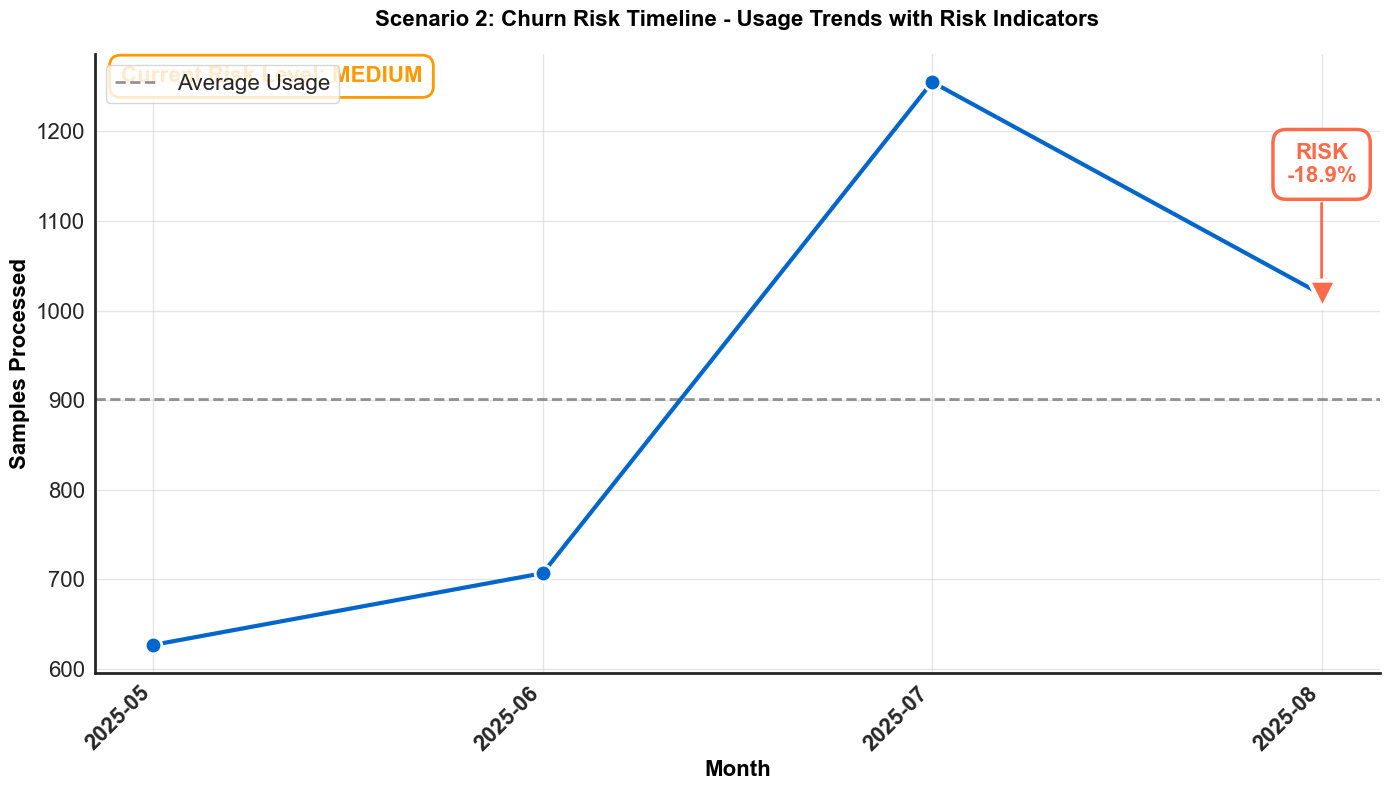

In [ ]:
# Scenario 2 - Visual 10: Churn Risk Timeline
# What we're showing: Usage trends with churn risk indicators
# Why: Visualizes churn risk over time to identify concerning patterns

visual10_churn_risk_timeline(usage_live, health_metrics)

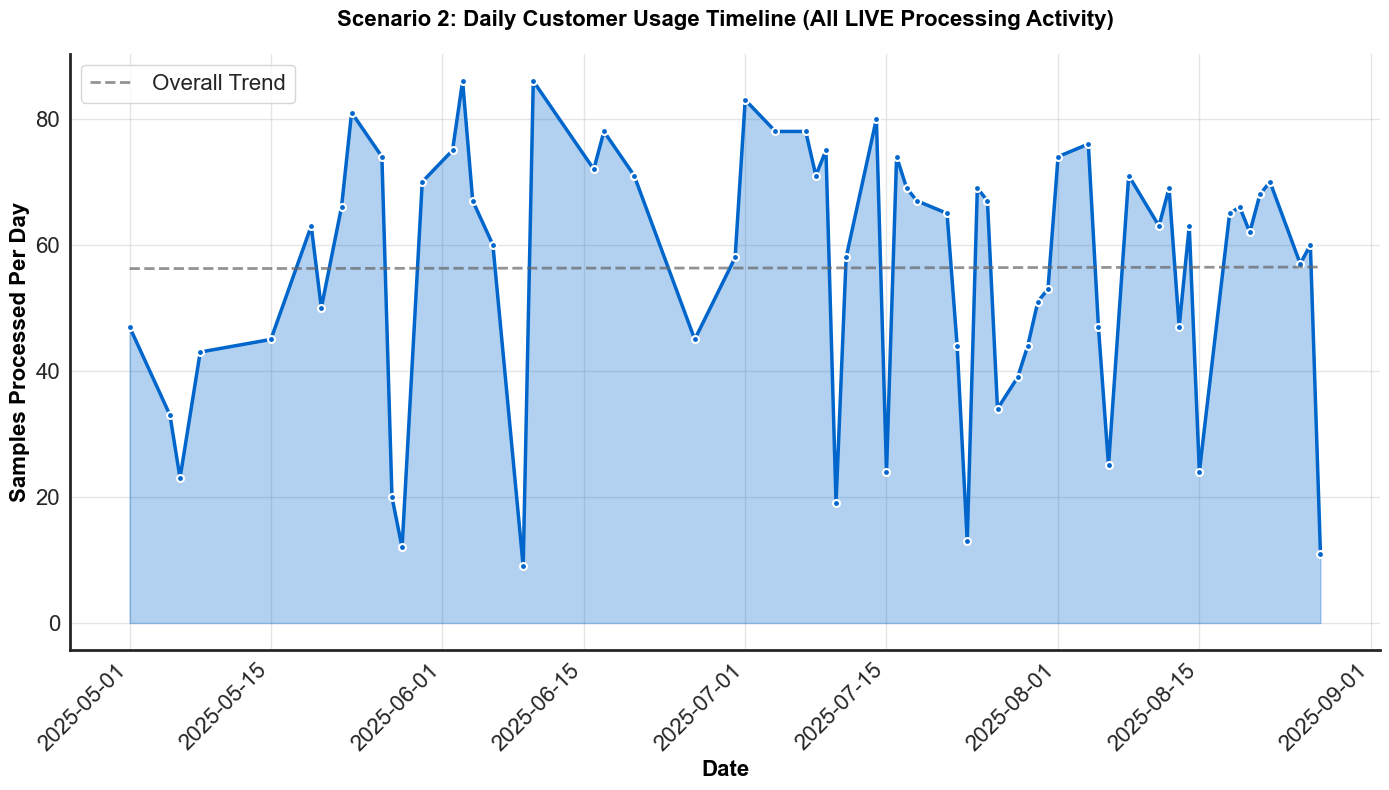

In [ ]:
# Scenario 2 - Visual 7: Daily Usage Timeline (All LIVE Processing)
# What we're showing: Daily usage patterns using all samples in LIVE runs
# Why: Shows actual customer usage regardless of QC outcome

visual7_daily_usage_timeline(usage_live)

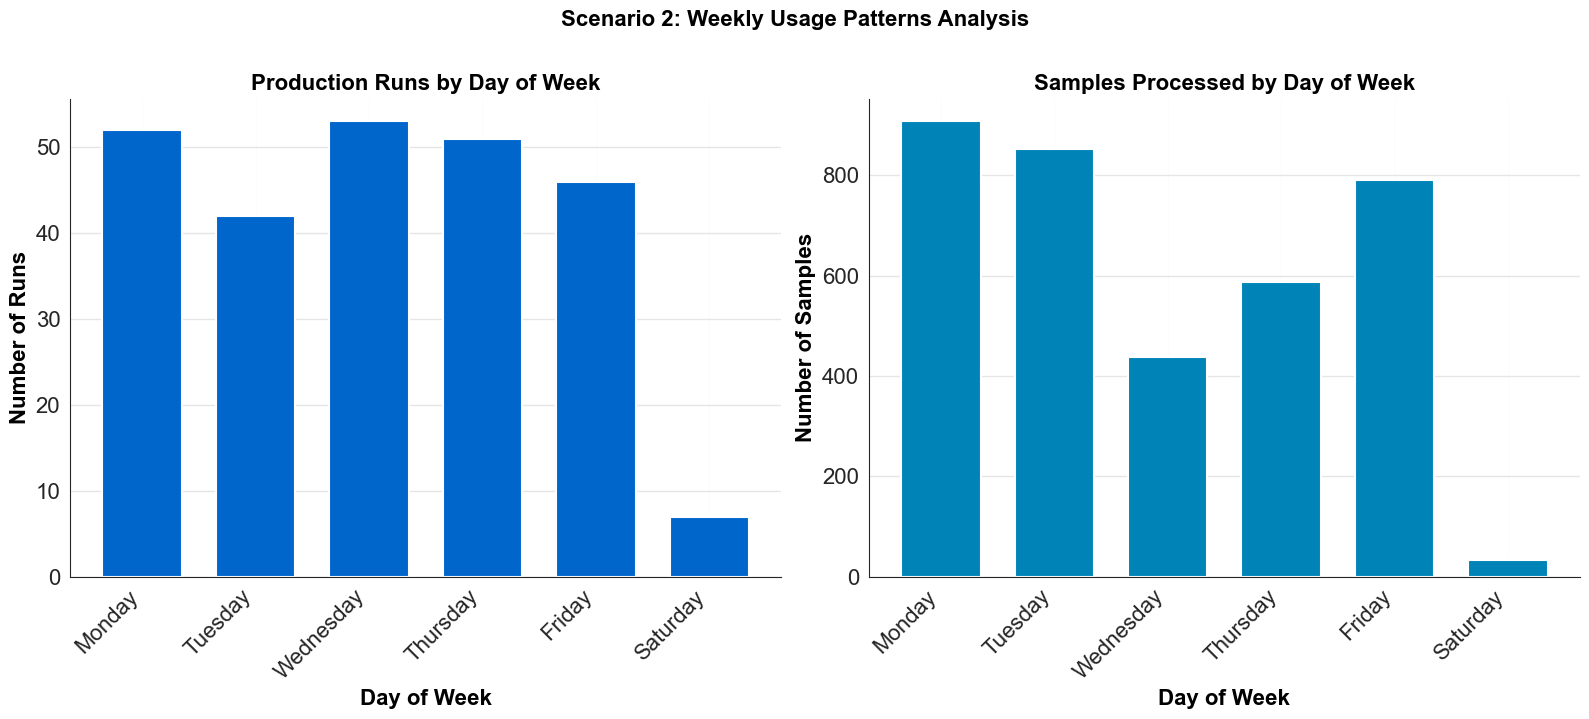

In [ ]:
# Scenario 2 - Visual 8: Weekly Usage Patterns
# What we're showing: Usage patterns by day of week
# Why: Identifies weekly operational cycles and business patterns

visual8_weekly_patterns(df_runs, usage_live)

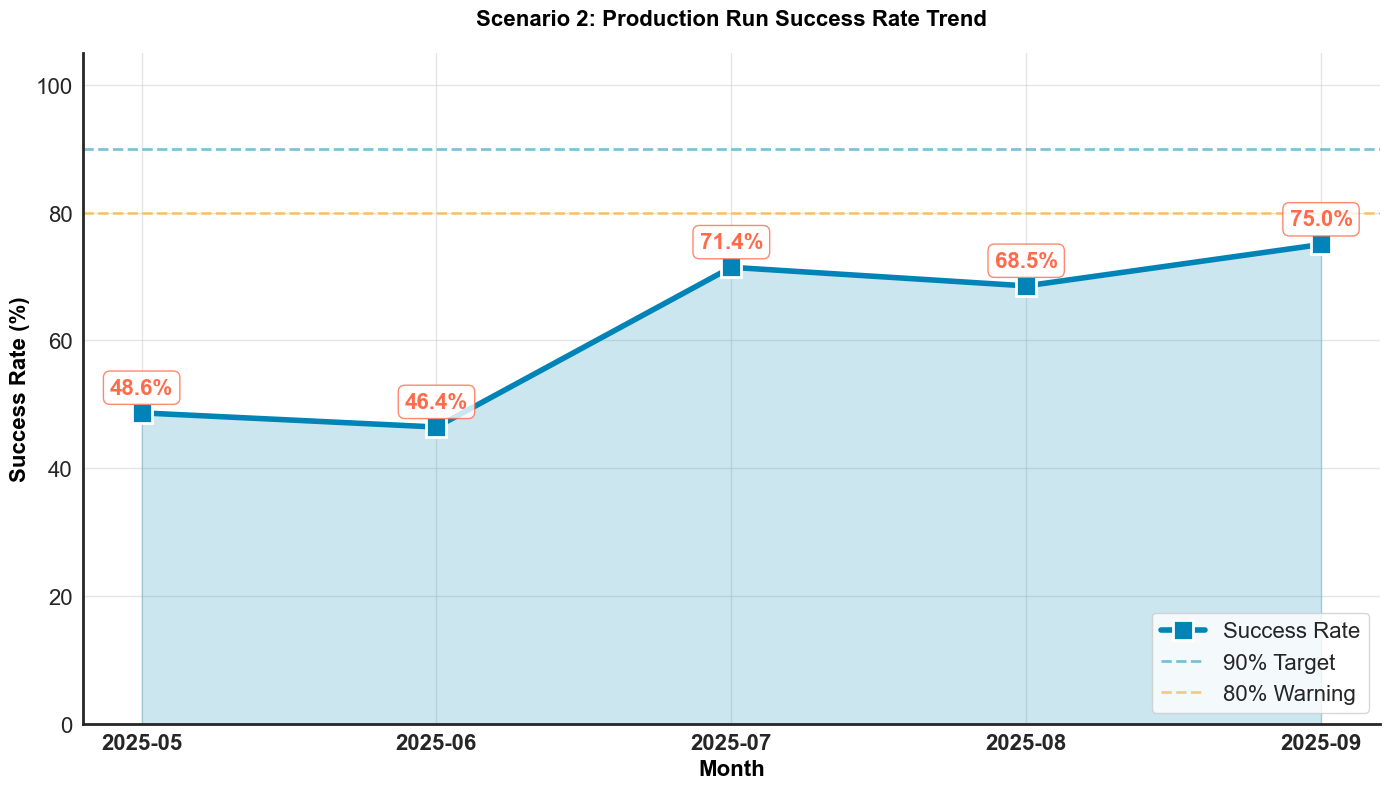

In [ ]:
# Scenario 2 - Visual 3: Production Run Success Rate
# What we're showing: Success rate trend over time and breakdown of run outcomes
# Why: Operational quality is a key indicator of customer satisfaction and risk

visual3_success_rate(df_runs)

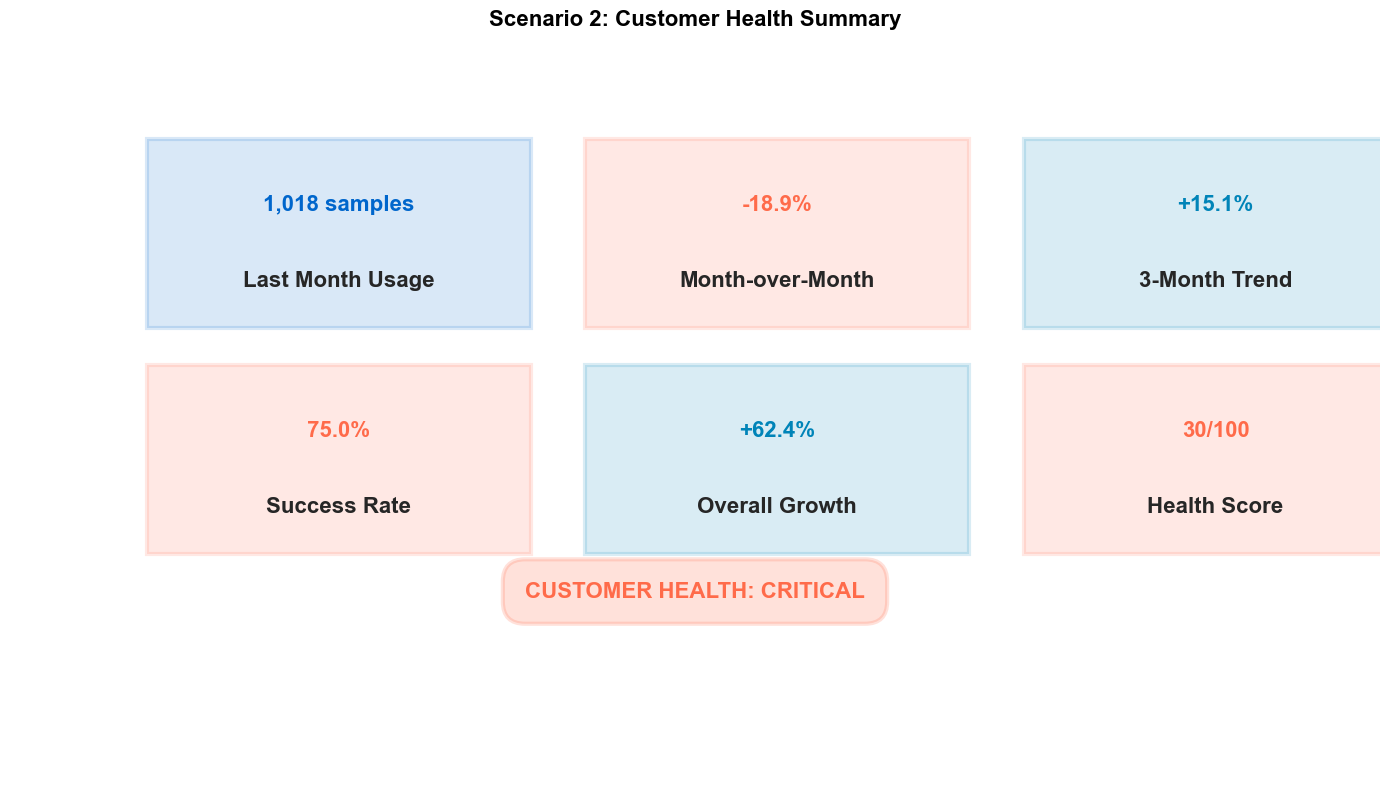

In [ ]:
# Scenario 2 - Visual 4: Customer Health Scorecard
# What we're showing: Comprehensive health score combining usage, growth, and quality metrics
# Why: Provides an at-a-glance assessment of overall customer health and risk level

visual4_health_summary(usage_live, df_runs)